1. Implement Q-learning and SARSA algorithm for cliff-walking environment.

2. Visualize  best policy (as sequence of images or vidoes  in Colab)

Template:

https://colab.research.google.com/drive/1BrFTeZsZWsgTi8b-iun7ZMT6Ivj-T2Kq?usp=sharing


In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym

import matplotlib.pyplot as plt


def render_as_image(env: gym.Env) -> None:
    """ Display the environment's current state as an image. """
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()


In [ ]:
from typing import Dict, List, Tuple, Union
import numpy as np
import gymnasium as gym

DEFAULT_QVALUE: float = 0.0
NEGATIVE_INF: float = -100.0


class Qtable:
    """ Class to store and manage Q-values for reinforcement learning."""

    def __init__(self, environment: gym.Env, zero_initial_values: bool = False) -> None:
        """ Initialize the Q-table. """
        # self.moves: List[Tuple[int, int]] = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.num_states: int = environment.observation_space.n
        self.num_actions: int = environment.action_space.n

        # Initialize Q-table with zeros or small random values
        if zero_initial_values:
            self.Q: np.ndarray = np.zeros((self.num_states, self.num_actions))
        else:
            self.Q: np.ndarray = np.random.uniform(0, 0.5, size=(self.num_states, self.num_actions))

    def set_qvalue(self, state: int, action: int, value: float) -> None:
        """ Set the Q-value for a given state-action pair. """
        self.Q[state, action] = value

    def get_qvalue(self, state: int, action: int) -> float:
        """ Get the Q-value for a given state-action pair. """
        return float(self.Q[state, action])

    def get_max_qvalue(self, state: int) -> float:
        """ Get the maximum Q-value for a given state. """
        return np.max(self.get_qvalue_vector(state))

    def get_qvalue_vector(self, state: int) -> np.ndarray:
        """ Get action values as vector indexed by env action space. """
        return self.Q[state]

    def get_state_values(self) -> Dict[int, float]:
        """ Get state values as maximum from state-action values originating from state. """
        return {state: self.get_max_qvalue(state) for state in range(self.num_states)}


class Agent:
    """ Class to initialize, train and run an agent to move in environment. """

    def __init__(self, starting_state: int = 0) -> None:
        """ Initialize the agent with default settings and a CliffWalking environment. """

        # Declaring environment
        self.environment: gym.Env = gym.make('CliffWalking-v0')

        # Initial state
        self.current_state: Union[int, None] = self.environment.reset()[0]

        self.lr: float = 0.01
        self.exp_rate: float = 0.3
        self.decay_gamma: float = 1.0

        # Initial state reward
        self.state_values: Dict[int, float] = {}
        self.state_visit_count: Dict[int, int] = {}

        # State trace information
        self.states_visited_trace: List[int] = []
        self.states_reward_trace: List[float] = []

        # Initial Q values
        self.Q_values: Qtable = Qtable(self.environment)

    def end_training(self) -> None:
        """ Close the environment after training. """
        self.environment.close()

    def playQ_learning(self, number_of_episodes: int = 1) -> None:
        """ Train the agent using the Q-learning algorithm. """

        episode_count = 0

        while episode_count < number_of_episodes:
            terminated, truncated = False, False

            self.reset()
            while not terminated and not truncated:
                # Choose an action using epsilon-greedy policy
                action = self.chooseActionEpsilonGreedyPolicy(self.current_state, self.exp_rate)

                # Take the action and observe the result
                next_state, reward, terminated, truncated, info = self.environment.step(action)

                # Get the current Q-value for the state-action pair
                current_q = self.Q_values.get_qvalue(self.current_state, action)

                # Get the maximum Q-value for the next state
                max_next_q = self.Q_values.get_max_qvalue(next_state)

                # Update the Q-value using the Q-learning update rule
                updated_q = current_q + self.lr * (float(reward) + self.decay_gamma * max_next_q - current_q)
                self.Q_values.set_qvalue(self.current_state, action, updated_q)

                # Update the agent state
                self.current_state = next_state

            episode_count += 1

        self.state_values = self.Q_values.get_state_values()
        self.end_training()

    def play_SARSA(self, number_of_episodes: int = 1) -> None:
        """ Train the agent using the SARSA algorithm. """

        episode_count = 0

        while episode_count < number_of_episodes:
            terminated, truncated = False, False

            # Choose the initial action using the epsilon-greedy policy
            action = self.chooseActionEpsilonGreedyPolicy(self.current_state, self.exp_rate)

            self.reset()
            while not terminated and not truncated:
                # Take the action and observe the result
                next_state, reward, terminated, truncated, info = self.environment.step(action)

                # Choose the next action using the epsilon-greedy policy
                next_action = self.chooseActionEpsilonGreedyPolicy(next_state, self.exp_rate)

                # Get the current Q-value for the state-action pair
                current_q = self.Q_values.get_qvalue(self.current_state, action)

                # Get the Q-value for the next state-action pair
                next_q = self.Q_values.get_qvalue(next_state, next_action)

                # Update the Q-value using the SARSA update rule
                updated_q = current_q + self.lr * (reward + self.decay_gamma * next_q - current_q)
                self.Q_values.set_qvalue(self.current_state, action, updated_q)

                # Update the agent state and action for the next iteration
                self.current_state = next_state
                action = next_action

            episode_count += 1

        self.state_values = self.Q_values.get_state_values()
        self.end_training()

    def follow_best_policy(self) -> None:
        """ Follow the best policy learned by the agent and render the environment at each step. """
        self.environment = gym.make('CliffWalking-v0', render_mode='rgb_array')

        self.current_state = self.environment.reset()[0]
        self.environment.render()
        i = 0
        r = 0.0
        terminated = False
        while not terminated:
            render_as_image(self.environment)
            print('State: ', self.current_state, '  ', self.Q_values.get_qvalue_vector(self.current_state))

            # epsilon = 0 => strictly greedy policy
            action = self.chooseActionEpsilonGreedyPolicy(self.current_state, epsilon=0.0)
            next_state, reward, terminated, truncated, info = self.environment.step(action)
            print(f'Step {i}: observation={next_state}, reward={reward}, done={terminated}')

            r += float(reward)
            i += 1
            self.current_state = next_state

        print(f"FINAL STATE".center(100, '-'))
        render_as_image(self.environment)

        print("Reward ", r)

    def chooseActionEpsilonGreedyPolicy(self, state: int, epsilon: float) -> int:
        """ Choose an action based on the epsilon-greedy policy. """

        if np.random.uniform(0, 1) < epsilon:
            # Exploration: choose a random action
            action = self.environment.action_space.sample()
        else:
            # Exploitation: choose the action with the highest Q-value
            q_values = self.Q_values.get_qvalue_vector(state)
            action = np.argmax(q_values)

        return action

    def reset(self) -> None:
        """ Reset the environment and traces for a new episode. """
        self.states_visited_trace = []
        self.states_reward_trace = []
        self.current_state = self.environment.reset()[0]

    def showValues(self) -> None:
        """ Display the state values in a grid format. """
        BOARD_ROWS = 4
        BOARD_COLS = 12

        print('---------STATE VALUES------------')
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                state_id = i * 12 + j
                value = self.state_values.get(state_id, 0.0)
                out += "{0:0.2f}".format(value).ljust(6) + ' | '
            print(out)
        print('----------------------------------')


agent = Agent()
agent.lr = 0.5
# agent.playQ_learning(500)
agent.play_SARSA(1000)
agent.showValues()



---------STATE VALUES------------
----------------------------------
| -39.79 | -37.03 | -33.88 | -29.81 | -26.61 | -25.05 | -23.44 | -18.69 | -13.50 | -13.45 | -8.47  | -2.99  | 
----------------------------------
| -44.98 | -38.55 | -38.09 | -39.01 | -34.39 | -29.99 | -19.94 | -25.42 | -18.95 | -17.97 | -5.87  | -1.59  | 
----------------------------------
| -45.02 | -49.04 | -43.88 | -40.05 | -36.53 | -43.88 | -37.20 | -29.69 | -21.03 | -33.01 | -5.59  | -0.54  | 
----------------------------------
| -53.05 | 0.26   | 0.44   | 0.41   | 0.28   | 0.35   | 0.31   | 0.48   | 0.39   | 0.49   | 0.36   | 0.47   | 
----------------------------------


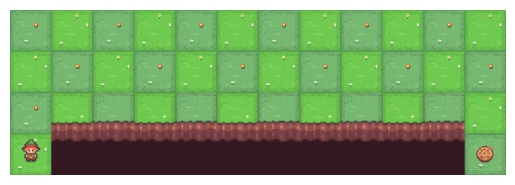

State:  36    [ -53.05129456 -175.50035282  -71.86268548  -79.35827992]
Step 0: observation=24, reward=-1, done=False


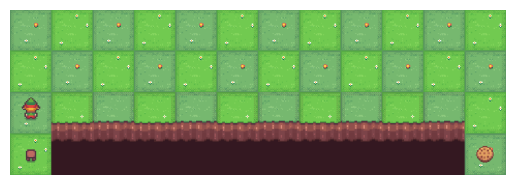

State:  24    [-45.01887938 -66.12840222 -77.69607788 -55.69446597]
Step 1: observation=12, reward=-1, done=False


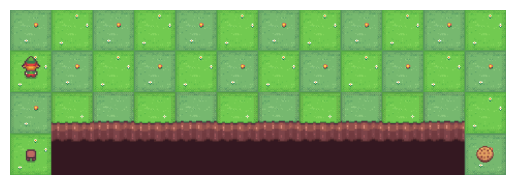

State:  12    [-44.97653708 -59.69550416 -54.05877145 -50.29162882]
Step 2: observation=0, reward=-1, done=False


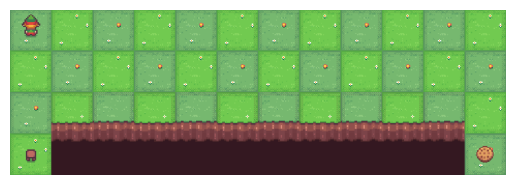

State:  0    [-45.43718138 -39.78697411 -45.19455269 -43.65997821]
Step 3: observation=1, reward=-1, done=False


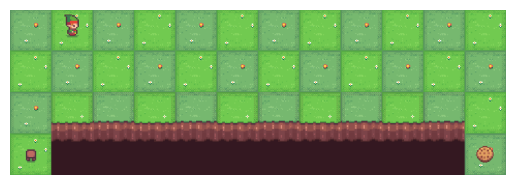

State:  1    [-41.00517289 -37.03234795 -45.27091699 -48.1837539 ]
Step 4: observation=2, reward=-1, done=False


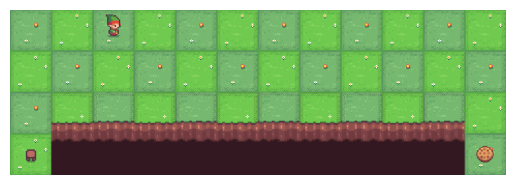

State:  2    [-45.72069315 -33.88333774 -41.31425577 -41.67492396]
Step 5: observation=3, reward=-1, done=False


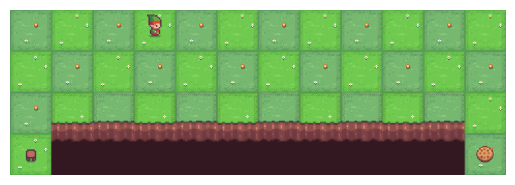

State:  3    [-33.08210574 -29.81452475 -37.73521177 -38.94563839]
Step 6: observation=4, reward=-1, done=False


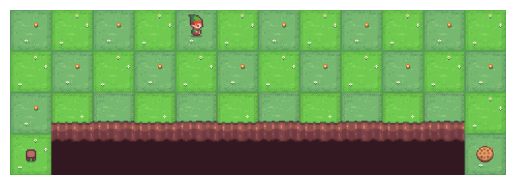

State:  4    [-38.48603519 -26.61084197 -38.73848584 -33.8214653 ]
Step 7: observation=5, reward=-1, done=False


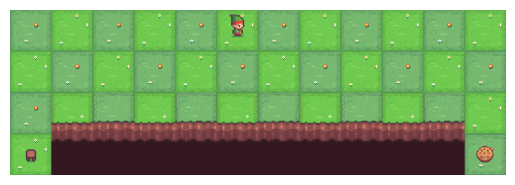

State:  5    [-33.91996381 -25.04570913 -34.11730775 -36.61098793]
Step 8: observation=6, reward=-1, done=False


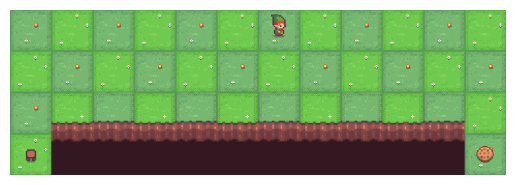

State:  6    [-30.48608883 -23.43526342 -28.93787939 -34.21134452]
Step 9: observation=7, reward=-1, done=False


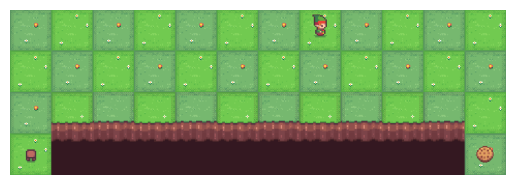

State:  7    [-24.89566351 -18.69179    -25.60393995 -25.5927051 ]
Step 10: observation=8, reward=-1, done=False


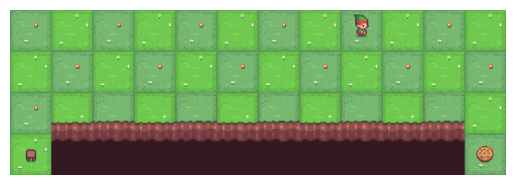

State:  8    [-18.93322349 -13.50275945 -23.71552921 -23.96911695]
Step 11: observation=9, reward=-1, done=False


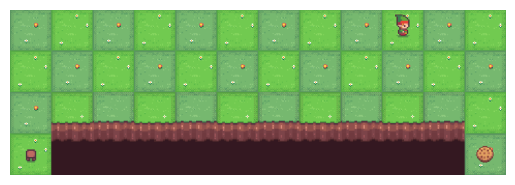

State:  9    [-14.6183233  -13.45179744 -24.23714872 -17.56652987]
Step 12: observation=10, reward=-1, done=False


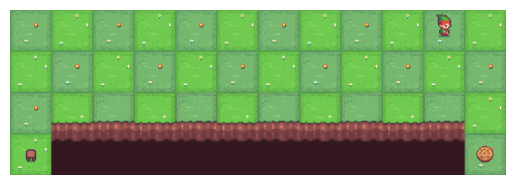

State:  10    [-12.97080488  -8.46727959 -15.85824217 -15.25646412]
Step 13: observation=11, reward=-1, done=False


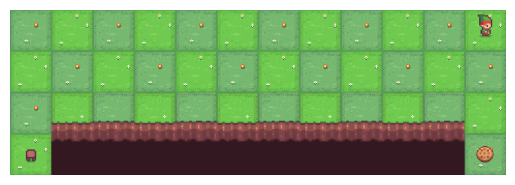

State:  11    [-11.40753439  -7.28190237  -2.98957141 -13.79350645]
Step 14: observation=23, reward=-1, done=False


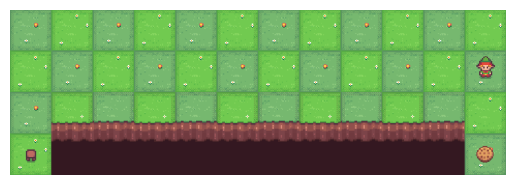

State:  23    [-14.49753049  -5.24979685  -1.58667656 -10.92380619]
Step 15: observation=35, reward=-1, done=False


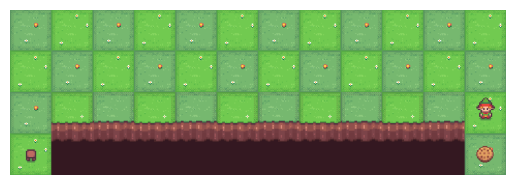

State:  35    [-9.33365031 -7.15048469 -0.54397984 -9.43262042]
Step 16: observation=47, reward=-1, done=True
--------------------------------------------FINAL STATE---------------------------------------------


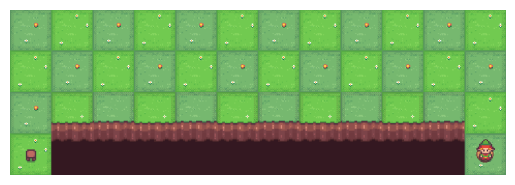

Reward  -17.0


In [ ]:
agent.follow_best_policy()